# 이 노트의 목표
---
raw database에서 좌표값구하기까지 정리

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# import

import librosa
import librosa.display
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.patches as patches
import io


In [3]:
# 경로지정

database_dir = '/content/drive/MyDrive/aiffel/AIFFELthon/1_data/ICBHI_final_database/'
train_test_dir = '/content/drive/MyDrive/aiffel/AIFFELthon/1_data/ICBHI_challenge_train_test.txt'


## 함수1 : get_dataframe(드러움)

1. return1 : wav, txt 파일명 반환하는 튜플리스트 -> [ (wav, txt), ...  ]
2. return2 : 오디오파일 df 생성

In [4]:
# dir내의 파일을 이름으로 같이 묶어서 반환하는 함수 -> [ (wav, txt), ( ... ), ... ]

def get_dataframe(database_dir, train_test_dir, sr = 8000):
    '''
    database_dir : raw database (include wav, txt files)
    train_test_dir: train, test 정보 포함된 txt 경로
    '''
    # 디렉토리 내의 모든 파일 목록을 가져옵니다.
    all_files = os.listdir(database_dir)

    wav_files = [file for file in all_files if file.endswith('.wav')]
    txt_files = [file for file in all_files if file.endswith('.txt')]

    # 파일명(확장자 제외)을 기준으로 .wav와 .txt 파일이 모두 있는 경우를 찾아서 짝지어 줍니다.
    wav_txt_name = []
    for wav_file in wav_files:
        file_name_without_extension = os.path.splitext(wav_file)[0] # 확장자를 제외한 파일명

        matching_txt_file = file_name_without_extension + '.txt' # 해당 파일명을 가진 .txt 파일이 있는지 확인
        if matching_txt_file in txt_files:
            wav_txt_name.append((wav_file, matching_txt_file)) # : wav_txt_name = [(filename.wav, filename.txt), ... ]
            # wav_txt_name -> "return1"

    # wav filename만 불러오고, duration 계산 -> "오래걸림"
    duration_ls = []
    wav_filename_ls = []
    for i, _ in wav_txt_name:          # wav 파일 이름만 가져옴
        wav_filename_ls.append(i)

        wav_path = database_dir + i
        y, sr = librosa.load(wav_path, sr=sr)
        duration = librosa.get_duration(y=y, sr=sr)
        duration_ls.append(duration)

    # ICBHI_challenge_train_test.txt 파일을 읽어서 DataFrame에 추가할 정보를 추출
    train_test_ls = []
    with open(train_test_dir, 'r') as file:
        for line in file:
            parts = line.strip().split('\t')
            filename = parts[0] + '.wav'  # WAV 파일 이름으로 변환
            train_test = parts[1]  # train 또는 test 값
            train_test_ls.append({'WAV Filename': filename, 'Train_Test': train_test})

    # get dataframe(1) - filename, duration
    wav_duration_df = pd.DataFrame({
        'WAV Filename': wav_filename_ls,
        'Duration': duration_ls
    })

    # ICBHI_challenge_train_test.txt 파일을 읽어서 DataFrame에 추가할 정보를 추출
    train_test_ls = []
    with open(train_test_dir, 'r') as file:
        for line in file:
            parts = line.strip().split('\t')
            filename = parts[0] + '.wav'  # WAV 파일 이름으로 변환
            train_test = parts[1]  # train 또는 test 값
            train_test_ls.append({'WAV Filename': filename, 'Train_Test': train_test})
    train_test_df = pd.DataFrame(train_test_ls)

    # get dataframe(2) : 원래 DataFrame과 새로운 DataFrame을 'WAV Filename'을 기준으로 병합 -> "return2"
    merged_df = pd.merge(wav_duration_df, train_test_df, on='WAV Filename', how='left')

    return wav_txt_name, merged_df


### test

In [5]:
# test -> 오디오파일 다불러와서 duration계산하는거때문에 오래걸림
wav_txt_name, merged_df = get_dataframe(database_dir, train_test_dir, sr = 8000)

In [6]:
# 결과 출력
print(type(wav_txt_name), type(merged_df))
print(len(wav_txt_name))
merged_df.head()

<class 'list'> <class 'pandas.core.frame.DataFrame'>
920


,WAV Filename,Duration,Train_Test
0,101_1b1_Al_sc_Meditron.wav,20.000,test
1,101_1b1_Pr_sc_Meditron.wav,20.000,test
2,102_1b1_Ar_sc_Meditron.wav,20.000,test
3,103_2b2_Ar_mc_LittC2SE.wav,20.000,train
4,104_1b1_Al_sc_Litt3200.wav,15.856,test


## 함수2 : get_annot_df
- 하나의 wav file에 대한 annotation df 반환
- 함수1 결과값 (`merged_df`)필요

```python
columns = ['WAV Filename', 'start', 'end', 'crackle', 'wheeze']
```

In [7]:
# merged_df idx정보로 annotation df 생성

def get_annot_df(idx, merged_df, database_dir):
    filename = merged_df['WAV Filename'][idx].replace('.wav', '.txt')
    txt_path = database_dir + filename
    annot_df = pd.read_csv(txt_path,
               sep='\t',
               names = ['start', 'end', 'crackle', 'wheeze'])
    annot_df.insert(0, 'WAV Filename', value=merged_df['WAV Filename'][idx])
    return annot_df


### test

In [8]:
# idx = 0
get_annot_df(0, merged_df, database_dir)
# idx = 376
get_annot_df(376, merged_df, database_dir)

,WAV Filename,start,end,crackle,wheeze
0,156_8b3_Ll_mc_AKGC417L.wav,1.935,4.185,1,0
1,156_8b3_Ll_mc_AKGC417L.wav,4.185,6.566,1,1
2,156_8b3_Ll_mc_AKGC417L.wav,6.566,8.601,1,1
3,156_8b3_Ll_mc_AKGC417L.wav,8.601,10.839,1,1
4,156_8b3_Ll_mc_AKGC417L.wav,10.839,13.185,1,1
5,156_8b3_Ll_mc_AKGC417L.wav,13.185,15.423,1,1
6,156_8b3_Ll_mc_AKGC417L.wav,15.423,17.613,1,1
7,156_8b3_Ll_mc_AKGC417L.wav,17.613,19.946,1,1


## 함수3: split_train_test_df
- 데이터베이스에 주어진 train-test대로 분리해서 df로 반환

In [9]:
# train-test df split

def split_train_test_df(merged_df):
    train_df = merged_df[merged_df['Train_Test'] == 'train']
    test_df = merged_df[merged_df['Train_Test'] == 'test']
    return train_df, test_df

### test

In [10]:
train_df, test_df = split_train_test_df(merged_df)

In [11]:
print(train_df.shape)
train_df.head()
print(test_df.shape)
test_df.head()

(538, 3)
(381, 3)


,WAV Filename,Duration,Train_Test
0,101_1b1_Al_sc_Meditron.wav,20.000,test
1,101_1b1_Pr_sc_Meditron.wav,20.000,test
2,102_1b1_Ar_sc_Meditron.wav,20.000,test
4,104_1b1_Al_sc_Litt3200.wav,15.856,test
5,104_1b1_Ar_sc_Litt3200.wav,25.584,test


## 함수4 : audio2mspec_save (드러움)
- 오디오 파일 경로랑 저장 경로, 이미지 픽셀 사이즈 지정해주면,
    - 저장 경로에 filename_mSpec.jpg 로 저장

- return값 없음

In [12]:
# convert_audio_to_melspectrogram

def audio2mspec_save(audio_path, save_path, size=(224, 224)):
    '''
    args:
        audio_path : 변환할 오디오 파일 경로
        save_path : 이미지 저장할 경로
        size : 변환할 이미지 pixel사이즈

    오디오 파일 경로를 받아서 저장 경로에 (224, 224, 3) 크기의 filename_mSpec.jpg 저장
    0. 변수 지정
    1. 파일이름, 디렉토리 정의
    2. audio -> mel
    3. mel -> image(jpg) -> resizing
    4. save image
    '''
    # 0. mel 변수 지정 -> 함수 매개변수로 옮겨도 되는 부분
    sample_rate = 8000  # 샘플링 레이트 (or 16000)
    n_mels = 64  # 멜 필터뱅크의 수
    nfft = 512  # FFT 윈도우 크기
    hop_length = nfft // 2  # 프레임 사이의 샘플 수
    f_max = 2000  # 최대 주파수

    # 1. .wav -> .jpg
    # .wav 파일 경로에서 디렉터리와 파일명(확장자 포함) 분리
    dir_path, filename = os.path.split(audio_path)
    # 파일명에서 확장자를 제거하고, .jpg 확장자를 추가
    base_filename = os.path.splitext(filename)[0]
    jpg_filename = f"{base_filename}_mSpec.jpg"
    # 디렉터리 내에 .jpg 파일 경로 생성
    save_path += jpg_filename


    # 2. to mel
    y, sr = librosa.load(audio_path, sr=sample_rate)
    S = librosa.feature.melspectrogram(y=y,
                                       sr=sr,
                                       n_fft=nfft,
                                       hop_length=hop_length,
                                       n_mels=n_mels,
                                       fmax=f_max)
    S_dB = librosa.power_to_db(S, ref=np.max)


    # 3. to img
    plt.figure(figsize=(2.24, 2.24))  # 이미지 크기를 인치 단위로 설정 (224x224 픽셀이 되도록 DPI 조정 필요)
    ax = plt.axes([0,0,1,1], frameon=False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.autoscale(tight=True)
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')

    # 이미지로 저장하기 전에 buffer에 저장
    plt.savefig(save_path, dpi=100)  # DPI를 조정하여 대략적인 픽셀 크기 맞춤
    #plt.savefig(save_path, bbox_inches='tight', pad_inches=0, dpi=100) # DPI를 조정하여 대략적인 픽셀 크기 맞춤
    plt.close()
    # 이미지를 다시 열어서 224x224x3으로 조정
    img = Image.open(save_path).convert('RGB')
    img = img.resize(size, Image.LANCZOS)


    # 4. save img
    if os.path.exists(save_path):
        pass
    else:
        img.save(save_path)

print('ㅎ')

ㅎ


### test

In [13]:
# 사용

save_path = '/content/drive/MyDrive/aiffel/AIFFELthon/1_data/224mel_database240311/'

wav_filename_ls = []
for i, _ in wav_txt_name:          # 함수1 return1에서 wav 파일 이름만 가져옴
    wav_filename_ls.append(i)

print(len(wav_filename_ls)) # 920

for audio_file_name in wav_filename_ls:
    audio_path = database_dir + audio_file_name

    #audio2mspec_save(audio_path, save_path, size=(224,224)) # 사용할때 주석 제거
    break

920


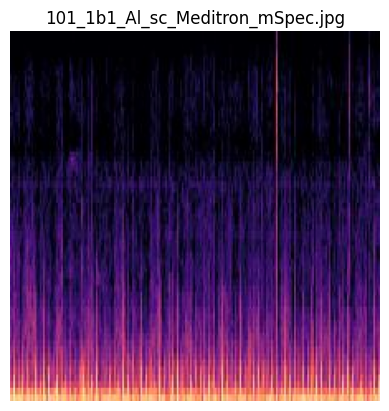

array([[[  0,   0,   4],
        [  0,   0,   4],
        [  0,   0,   4],
        ...,
        [  0,   0,   5],
        [  2,   1,   6],
        [  0,   0,   4]],

       [[  0,   0,   4],
        [  0,   0,   4],
        [  0,   0,   4],
        ...,
        [  0,   0,   4],
        [  2,   1,   6],
        [  0,   0,   4]],

       [[  0,   0,   4],
        [  0,   0,   4],
        [  0,   0,   4],
        ...,
        [  0,   0,   4],
        [  2,   1,   6],
        [  0,   0,   2]],

       ...,

       [[255, 196, 144],
        [236, 181, 125],
        [255, 231, 169],
        ...,
        [255, 204, 139],
        [238, 175, 121],
        [255, 209, 158]],

       [[254, 201, 149],
        [236, 189, 133],
        [255, 232, 170],
        ...,
        [255, 208, 148],
        [239, 183, 134],
        [255, 212, 169]],

       [[249, 199, 146],
        [235, 190, 133],
        [255, 229, 168],
        ...,
        [249, 198, 141],
        [237, 183, 137],
        [255, 210, 171]]], dtype=uint8)
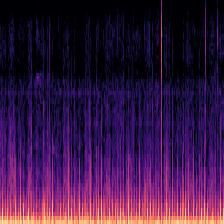

In [14]:
# sample file 확인
image_file = '/content/drive/MyDrive/aiffel/AIFFELthon/1_data/224mel_database240311/101_1b1_Al_sc_Meditron_mSpec.jpg'

tmp_img = Image.open(image_file)
tmp = np.array(tmp_img)

plt.figure()
plt.imshow(tmp_img)
plt.title(os.path.basename(image_file))
plt.axis('off')  # 축 표시 안 함
plt.show()

tmp

## 함수5: sample_file_load

파일명으로 sample image (`audio2mspec_save`로 저장한) 가져오는 함수 임시로 작성

- 표현 좋은 데이터 파일명 : 156_8b3_Ll_mc_AKGC417L.wav ~ idx: 376
- 레이블 고른 데이터 파일명 : 110_1p1_Al_sc_Meditron.wav ~ idx: 49

In [15]:
# 파일명으로 sample file 가져오는 함수 임시로 작성

def sample_file_load(filename):

    save_path = '/content/drive/MyDrive/aiffel/AIFFELthon/1_data/224mel_database240311/'
    audio_path = '/content/drive/MyDrive/aiffel/AIFFELthon/1_data/ICBHI_final_database/' + filename
    audio2mspec_save(audio_path, save_path, size=(224,224))

    # sample file 확인
    img_dir = save_path + filename.replace('.wav', '_mSpec.jpg')
    print(img_dir)
    # load : '110_1p1_Al_sc_Meditron.wav'
    sample_img = Image.open(img_dir)
    sample_img_array = np.array(sample_img)
    '''
    plt.figure()
    plt.imshow(tmp_img)
    plt.title(os.path.basename(image_file))
    plt.axis('off')  # 축 표시 안 함
    plt.show()
    '''
    print(filename)
    print(type(sample_img))
    print(type(sample_img_array))
    #sample_img_array

    return sample_img

### test

/content/drive/MyDrive/aiffel/AIFFELthon/1_data/224mel_database240311/156_8b3_Ll_mc_AKGC417L_mSpec.jpg
156_8b3_Ll_mc_AKGC417L.wav
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
idx:  376


,WAV Filename,start,end,crackle,wheeze
0,156_8b3_Ll_mc_AKGC417L.wav,1.935,4.185,1,0
1,156_8b3_Ll_mc_AKGC417L.wav,4.185,6.566,1,1
2,156_8b3_Ll_mc_AKGC417L.wav,6.566,8.601,1,1
3,156_8b3_Ll_mc_AKGC417L.wav,8.601,10.839,1,1
4,156_8b3_Ll_mc_AKGC417L.wav,10.839,13.185,1,1
5,156_8b3_Ll_mc_AKGC417L.wav,13.185,15.423,1,1
6,156_8b3_Ll_mc_AKGC417L.wav,15.423,17.613,1,1
7,156_8b3_Ll_mc_AKGC417L.wav,17.613,19.946,1,1


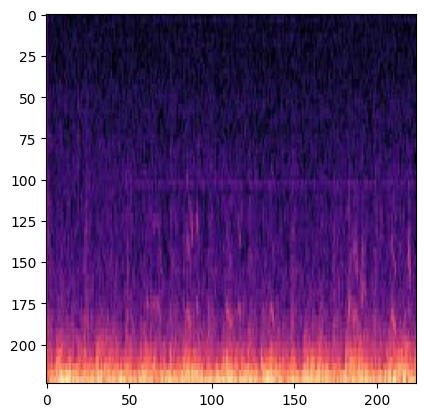

In [16]:
# 110_1p1_Al_sc_Meditron

# 원하는 파일 이름 입력
sample_filename = '156_8b3_Ll_mc_AKGC417L.wav'

sample_img = sample_file_load(sample_filename)
plt.imshow(sample_img)
print('idx: ', merged_df.loc[merged_df['WAV Filename'] == sample_filename].index[0])
get_annot_df(merged_df.loc[merged_df['WAV Filename'] == sample_filename].index[0], merged_df, database_dir)

## 함수6: get_coordinate_df

좌표값 포함 dataframe 반환 ~ get_annot_df(idx, merged_df, database_dir)로 접근

In [18]:
def get_coordinate_df(idx, merged_df, database_dir):

    idx_anno_df = get_annot_df(idx, merged_df, database_dir)

    f_max = 2000
    wheeze_fmin = 200
    wheeze_fmax = 1200
    crackle_fmin = 100
    crackle_fmax = 200

    filename = merged_df['WAV Filename'][idx]
    duration = merged_df['Duration'][idx]

    # if idx > 49:
    #     continue
    # # sample idx: 49
    # if idx == 49:

    ls = []
    tmp_ls = []

    for idx2, row2 in idx_anno_df.iterrows():
        start = row2['start']
        end = row2['end']
        crackle = row2['crackle']
        wheeze = row2['wheeze']
        x1 = start / duration
        x2 = end / duration

        if crackle and wheeze:
            c_y1 = 1 - (crackle_fmin / f_max)
            c_y2 = 1 - (crackle_fmax / f_max)
            w_y1 = 1 - (wheeze_fmin / f_max)
            w_y2 = 1 - (wheeze_fmax / f_max)
            tmp_ls = [x1, c_y1, x2, c_y2, x1, w_y1, x2, w_y2]

        elif crackle and not wheeze:
            c_y1 = 1 - (crackle_fmin / f_max)
            c_y2 = 1 - (crackle_fmax / f_max)
            tmp_ls = [x1, c_y1, x2, c_y2, '', '', '', '']

        elif not crackle and wheeze:
            w_y1 = 1 - (wheeze_fmin / f_max)
            w_y2 = 1 - (wheeze_fmax / f_max)
            tmp_ls = ['', '', '', '', x1, w_y1, x2, w_y2]

        else: tmp_ls = ['', '', '', '', '', '', '', '']

        ls.append(tmp_ls)

    coordinate_df = pd.DataFrame(ls, columns = ['x_c1','y_c1','x_c2','y_c2','x_w1','y_w1','x_w2','y_w2'])
    concat_df = pd.concat([idx_anno_df, coordinate_df], axis=1)


    return concat_df

### test

In [20]:
# test1: 전체 데이터프레임 보려할때

for i, _ in merged_df.iterrows():
    print('idx: ', i)
    concat_df = get_coordinate_df(i, merged_df, database_dir)
    break

concat_df

idx:  0


,WAV Filename,start,end,crackle,wheeze,x_c1,y_c1,x_c2,y_c2,x_w1,y_w1,x_w2,y_w2
0,101_1b1_Al_sc_Meditron.wav,0.036,0.579,0,0,,,,,,,,
1,101_1b1_Al_sc_Meditron.wav,0.579,2.450,0,0,,,,,,,,
2,101_1b1_Al_sc_Meditron.wav,2.450,3.893,0,0,,,,,,,,
3,101_1b1_Al_sc_Meditron.wav,3.893,5.793,0,0,,,,,,,,
4,101_1b1_Al_sc_Meditron.wav,5.793,7.521,0,0,,,,,,,,
5,101_1b1_Al_sc_Meditron.wav,7.521,9.279,0,0,,,,,,,,
6,101_1b1_Al_sc_Meditron.wav,9.279,11.150,0,0,,,,,,,,
7,101_1b1_Al_sc_Meditron.wav,11.150,13.036,0,0,,,,,,,,
8,101_1b1_Al_sc_Meditron.wav,13.036,14.721,0,0,,,,,,,,
9,101_1b1_Al_sc_Meditron.wav,14.721,16.707,0,0,,,,,,,,


In [21]:
# test2: 파일명으로 좌표값 포함된 샘플 데이터프레임 하나 작성
''' 156_8b3_Ll_mc_AKGC417L.wav -> idx: 376 '''

sample_filename = '156_8b3_Ll_mc_AKGC417L.wav'
sample_coo = get_coordinate_df(merged_df.loc[merged_df['WAV Filename'] == sample_filename].index[0], merged_df, database_dir)

sample_coo

,WAV Filename,start,end,crackle,wheeze,x_c1,y_c1,x_c2,y_c2,x_w1,y_w1,x_w2,y_w2
0,156_8b3_Ll_mc_AKGC417L.wav,1.935,4.185,1,0,0.09675,0.95,0.20925,0.9,,,,
1,156_8b3_Ll_mc_AKGC417L.wav,4.185,6.566,1,1,0.20925,0.95,0.32830,0.9,0.20925,0.9,0.3283,0.4
2,156_8b3_Ll_mc_AKGC417L.wav,6.566,8.601,1,1,0.32830,0.95,0.43005,0.9,0.3283,0.9,0.43005,0.4
3,156_8b3_Ll_mc_AKGC417L.wav,8.601,10.839,1,1,0.43005,0.95,0.54195,0.9,0.43005,0.9,0.54195,0.4
4,156_8b3_Ll_mc_AKGC417L.wav,10.839,13.185,1,1,0.54195,0.95,0.65925,0.9,0.54195,0.9,0.65925,0.4
5,156_8b3_Ll_mc_AKGC417L.wav,13.185,15.423,1,1,0.65925,0.95,0.77115,0.9,0.65925,0.9,0.77115,0.4
6,156_8b3_Ll_mc_AKGC417L.wav,15.423,17.613,1,1,0.77115,0.95,0.88065,0.9,0.77115,0.9,0.88065,0.4
7,156_8b3_Ll_mc_AKGC417L.wav,17.613,19.946,1,1,0.88065,0.95,0.99730,0.9,0.88065,0.9,0.9973,0.4


In [22]:
# test3: 인덱스만 줘서 반환
''' idx: 49 -> 110_1p1_Al_sc_Meditron.wav '''

sample_coo2 = get_coordinate_df(49, merged_df, database_dir)
sample_coo2

,WAV Filename,start,end,crackle,wheeze,x_c1,y_c1,x_c2,y_c2,x_w1,y_w1,x_w2,y_w2
0,110_1p1_Al_sc_Meditron.wav,2.2855,6.2646,1,1,0.070759,0.95,0.19395,0.9,0.070759,0.9,0.19395,0.4
1,110_1p1_Al_sc_Meditron.wav,6.2646,10.4400,1,1,0.19395,0.95,0.32322,0.9,0.19395,0.9,0.32322,0.4
2,110_1p1_Al_sc_Meditron.wav,10.4400,14.1120,1,1,0.32322,0.95,0.436904,0.9,0.32322,0.9,0.436904,0.4
3,110_1p1_Al_sc_Meditron.wav,14.1120,18.2170,1,0,0.436904,0.95,0.563994,0.9,,,,
4,110_1p1_Al_sc_Meditron.wav,18.2170,23.1110,0,0,,,,,,,,
5,110_1p1_Al_sc_Meditron.wav,23.1110,26.6580,1,0,0.715511,0.95,0.825325,0.9,,,,
6,110_1p1_Al_sc_Meditron.wav,26.6580,32.3000,1,0,0.825325,0.95,1.0,0.9,,,,


## 결과: bbox 시각화



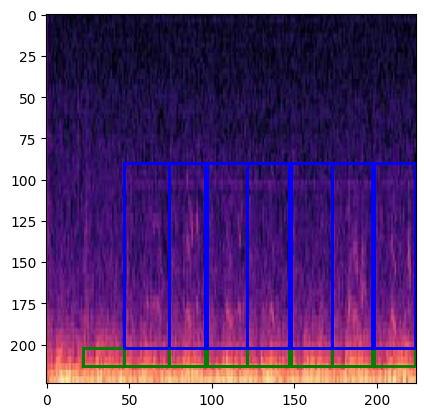

In [30]:
# 샘플파일이름 주면 박스 시각화
sample_filename = '156_8b3_Ll_mc_AKGC417L.wav'
#sample_filename2 = '110_1p1_Al_sc_Meditron.wav'

# 샘플이미지 index 가져옴
sample_idx = merged_df.loc[merged_df['WAV Filename'] == sample_filename].index[0]

# 샘플이미지에 대한 어노테이션+좌표값 데이터프레임 형성. sample_coordinate -> pd.Dataframe
sample_coordinate = get_coordinate_df(sample_idx, merged_df, database_dir)


fig, ax = plt.subplots()
ax.imshow(sample_img)

c_boxes = []
w_boxes = []
pix_size = 224

for idx, row in sample_coordinate.iterrows():

    # coordinate dataframe에서 좌표값만 불러와서 변수에 저장 -> 이부분 함수로 다시 작성 필요

    # crackle
    if row['crackle']:
        x_c1 = round(row['x_c1'] * pix_size)
        y_c1 = round(row['y_c1'] * pix_size)
        w_c = round((row['x_c2'] - row['x_c1']) * pix_size)
        h_c = round(-(row['y_c1'] - row['y_c2']) * pix_size)
        c_boxes.append((x_c1,y_c1,w_c,h_c))

    elif not row['crackle']:
        c_boxes.append(())

    # wheeze
    if row['wheeze']:
        x_w1 = round(row['x_w1'] * pix_size)
        y_w1 = round(row['y_w1'] * pix_size)
        w_w = round((row['x_w2'] - row['x_w1']) * pix_size)
        h_w = round(-(row['y_w1'] - row['y_w2']) * pix_size)
        w_boxes.append((x_w1,y_w1,w_w,h_w))

    elif not row['wheeze']:
        w_boxes.append(())

    # ax에 박스 입력
    for box in c_boxes:
        try :
            c_rect = patches.Rectangle((box[0], box[1]), box[2], box[3], linewidth=2, edgecolor='g', facecolor='none')
            ax.add_patch(c_rect)
        except:
            pass

    for box in w_boxes:
        try:
            b_rect = patches.Rectangle((box[0], box[1]), box[2], box[3], linewidth=2, edgecolor='b', facecolor='none')
            ax.add_patch(b_rect)
        except:
            pass


# 이부분은 다른 블럭에서 이미지 보고 싶을때 (GPT)

# 이미지를 버퍼에 저장
buf = io.BytesIO()
plt.savefig(buf, format='jpg')
buf.seek(0)
# boxed_img 변수에 박스친 이미지 저장
boxed_img = Image.open(buf)
# NumPy 배열로 변환
boxed_img_array = np.array(boxed_img)
# 버퍼 닫기
buf.close()

# 이미지 배열 확인
#print(image_array.shape)

# 출력
plt.show()


<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
(480, 640, 3)


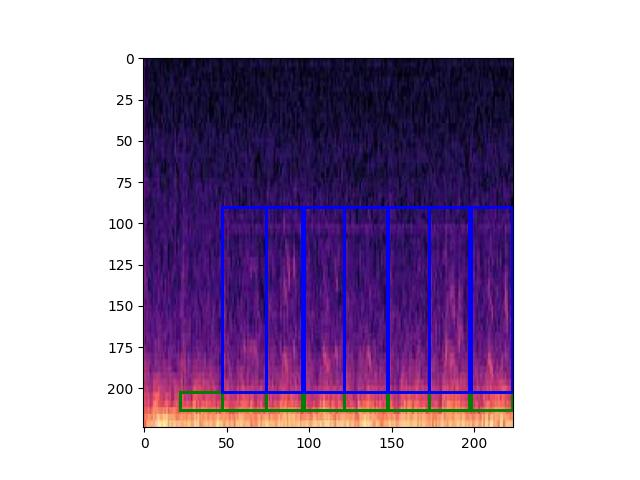

In [32]:
# 버퍼로 저장한 이미지 확인
print(type(boxed_img))
print(type(boxed_img_array))
print(boxed_img_array.shape) # 예시이미지라 크기 상관없음

boxed_img